In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

# Task 1

## Task 1.1

TODO pokec

In [ ]:
#| echo: true
rng = lambda: np.random.random()
dist = lambda n1, n2: np.sqrt((n1[0] - n2[0])**2 + (n1[1] - n2[1])**2)
p = lambda d, alpha, beta : beta * np.exp(-alpha * d)

def KaiserHilgetag(alpha = 1, beta = 1, N = 100):
    adjacency = np.zeros((N, N))
    neurons = [(rng(), rng())]
    while(len(neurons) < N):
        new_neuron = (rng(), rng())
        dists = [dist(new_neuron, n) for n in neurons]
        neighbours = [i for i, d in enumerate(dists) if random.random() < p(d, alpha, beta)]
        if len(neighbours) > 0:
            neurons.append(new_neuron)
            for i in neighbours:
                adjacency[i, len(neurons)-1] = 1
                adjacency[len(neurons)-1, i] = 1

    return adjacency, neurons

## Task 1.2

TODO pokec

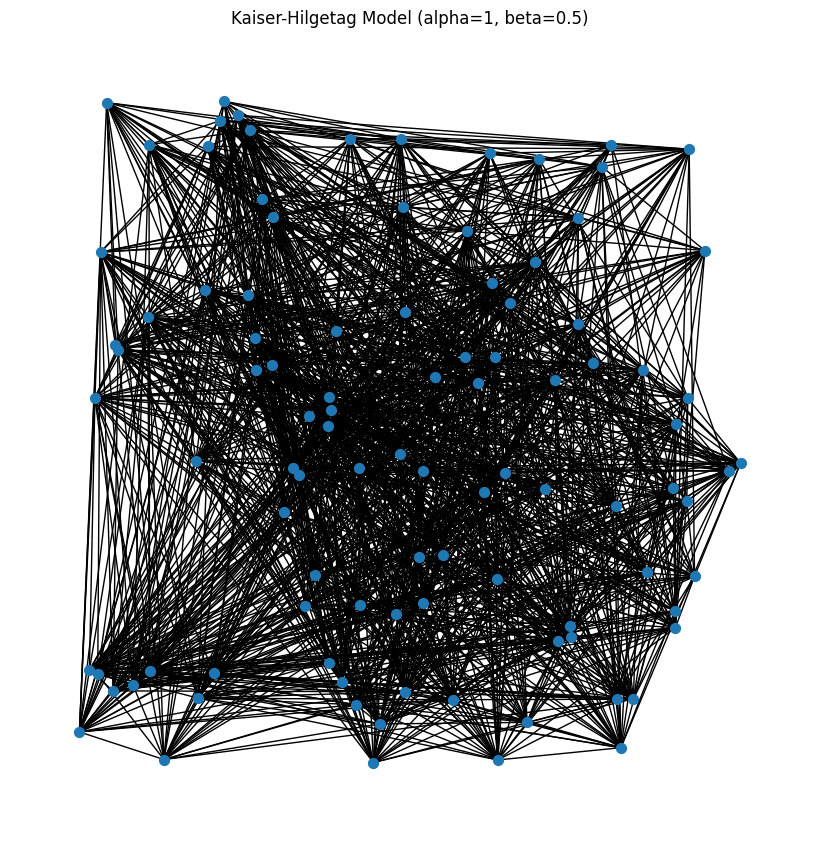

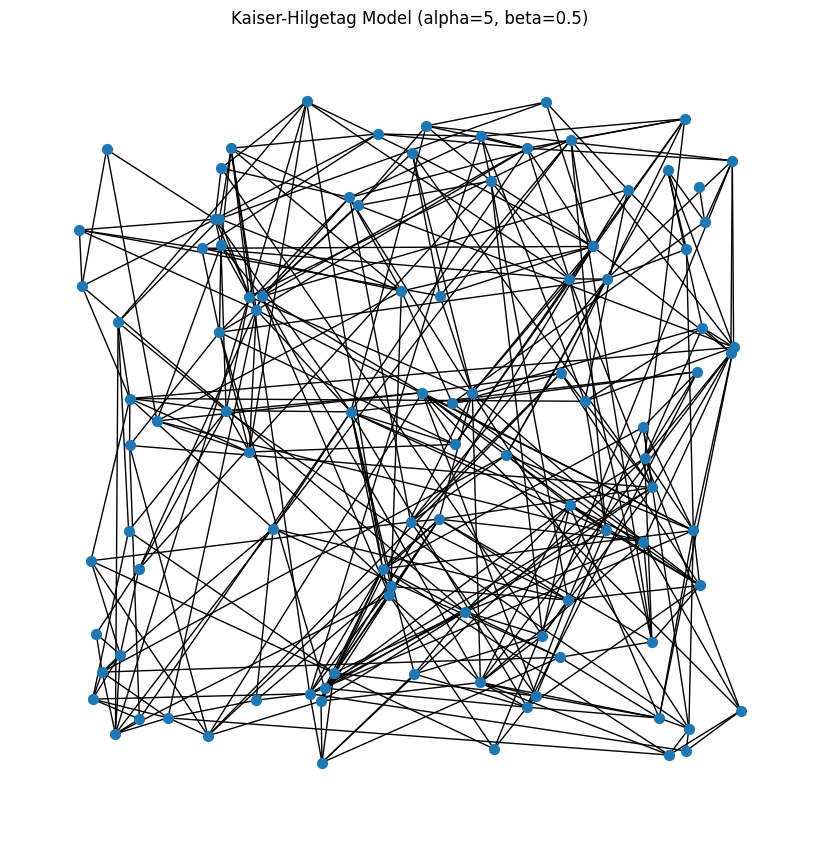

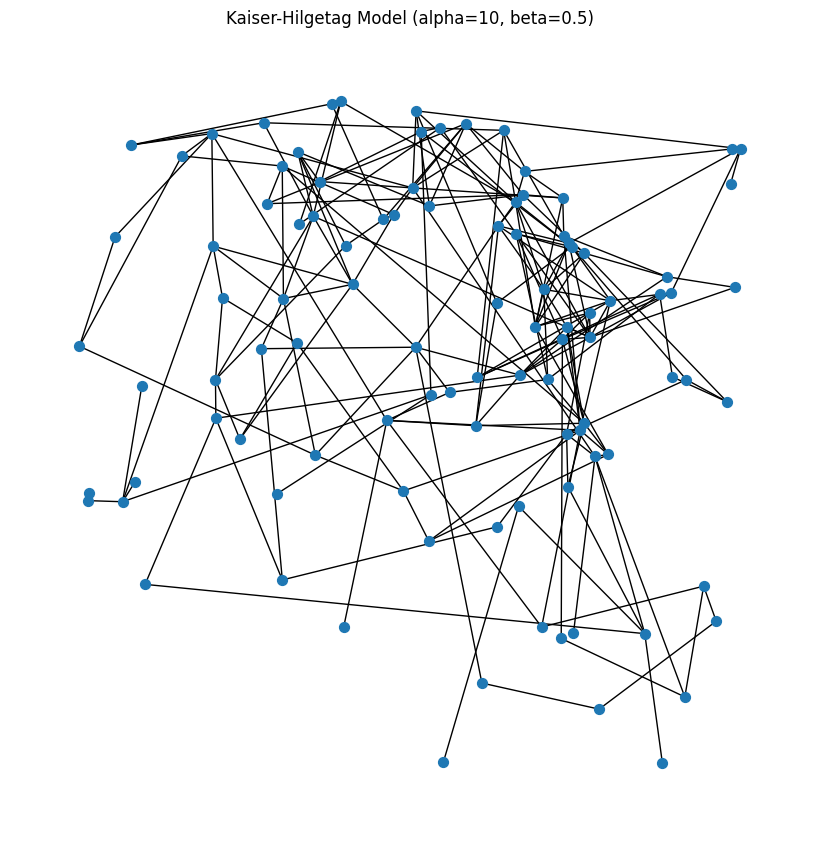

In [3]:
results = [
    KaiserHilgetag(alpha=1, beta=0.5, N=100),
    KaiserHilgetag(alpha=5, beta=0.5, N=100),
    KaiserHilgetag(alpha=10, beta=0.5, N=100)
]
alpha_values = [1, 5, 10]

def plot_graph(G, positions, title="Graph"):
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos={j: positions[j] for j in range(len(positions))}, node_size=50, with_labels=False)
    plt.title(title)

def plot_adjacency_matrix(adjacency, title="Adjacecncy Matrix"):
    plt.figure(figsize=(6, 6))
    plt.imshow(adjacency)
    plt.title(title)
    plt.xlabel('Neuron Index')
    plt.ylabel('Neuron Index')
    plt.colorbar(label='Connection Presence')

for i, (adjacency, positions) in enumerate(results):
    G = nx.from_numpy_array(adjacency)
    plot_graph(G, positions, title=f'Kaiser-Hilgetag Model (alpha={ alpha_values[i] }, beta=0.5)')
    plt.show()


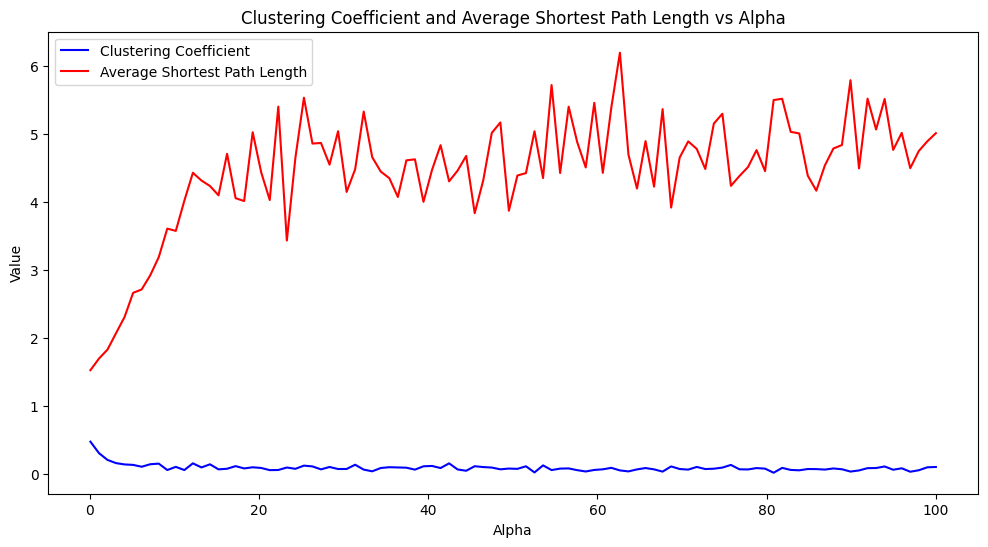

In [ ]:
cluster_coefficients = []
average_shortest_paths = []
alphas = np.linspace(0.1, 100, 100)

for i, alpha in enumerate(alphas):
    print(f'Calculating for alpha {i+1}/{len(alphas)}', end='\r')
    adjacency, _ = KaiserHilgetag(alpha=alpha, beta=0.5, N=100)
    G = nx.from_numpy_array(adjacency)
    cluster_coefficients.append(nx.average_clustering(G))
    
    average_shortest_paths.append(nx.average_shortest_path_length(G))

plt.figure(figsize=(12, 6))
plt.plot(alphas, cluster_coefficients, label='Clustering Coefficient', color='blue')
plt.plot(alphas, average_shortest_paths, label='Average Shortest Path Length', color='red')
plt.xlabel('Alpha')
plt.ylabel('Value')
plt.title('Clustering Coefficient and Average Shortest Path Length vs Alpha')
plt.legend()
plt.show()


In [ ]:
epsilon = 0.1

shortest_p = 2.636455440545317
avg_clustering = 0.22784965779174798



neviem = np.where((np.array(average_shortest_paths) < shortest_p + epsilon) & (np.array(average_shortest_paths) > shortest_p - epsilon) &
         (np.array(cluster_coefficients) < avg_clustering + epsilon) & (np.array(cluster_coefficients) > avg_clustering - epsilon))

print("Alpha values yielding desired properties:", alphas[neviem])

Alpha values yielding desired properties: [5.14545455]


# Task 2

## Task 2.1

In [ ]:
#! echo: true
pImproved = lambda d, alpha : np.exp(-alpha * d)

def ImprovedAlgorithmEfficient(alpha=1, N=100):
    positions = [(rng(), rng()) for _ in range(N)]
    # distances = np.fromfunction(lambda i, j: dist(positions[i], positions[j]), (N, N), dtype=int)
    distances = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distances[i, j] = dist(positions[i], positions[j])
    rho = 0.1
    N2 = N*(N-1)

    edges = 0
    
    adjacency = np.zeros((N, N))
    probabilities = p2(distances, alpha)
    np.fill_diagonal(probabilities, 0)
    probabilities /= np.sum(probabilities)
    
    i = 0

    while edges < N2 * rho:
        # print("Iteration ", i)
        i+=1
        rng_matrix = np.random.random((N, N))
        # rng_matrix = rng()
        
        new_edges = (rng_matrix < probabilities)
        if edges + np.sum(new_edges) > N2 * rho:
            diff = np.ceil(N2 * rho - edges)
            new_edges_flat = new_edges.flatten()
            indices = np.where(new_edges_flat)[0]
            selected_indices = np.random.choice(indices, size=int(diff), replace=False)
            new_edges_flat[:] = 0
            new_edges_flat[selected_indices] = 1
            new_edges = new_edges_flat.reshape((N, N))

        edges += np.sum(new_edges)

        adjacency += new_edges
    # print(f"Total edges created: {edges} checksum : {np.sum(adjacency)} and wanted : {N2 * rho}")

    return adjacency, positions

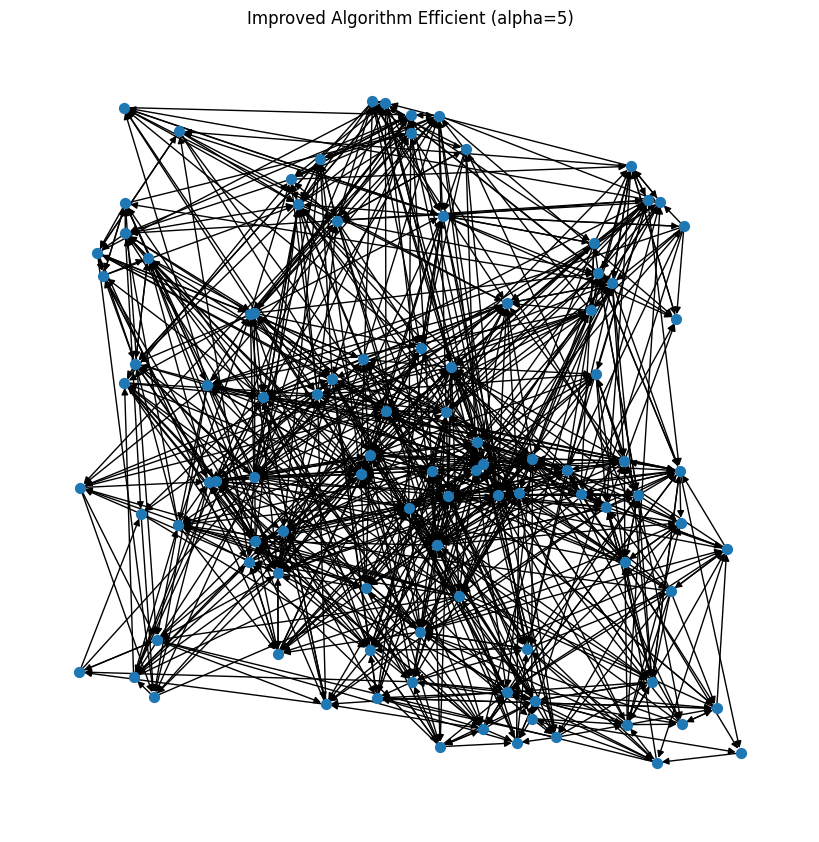

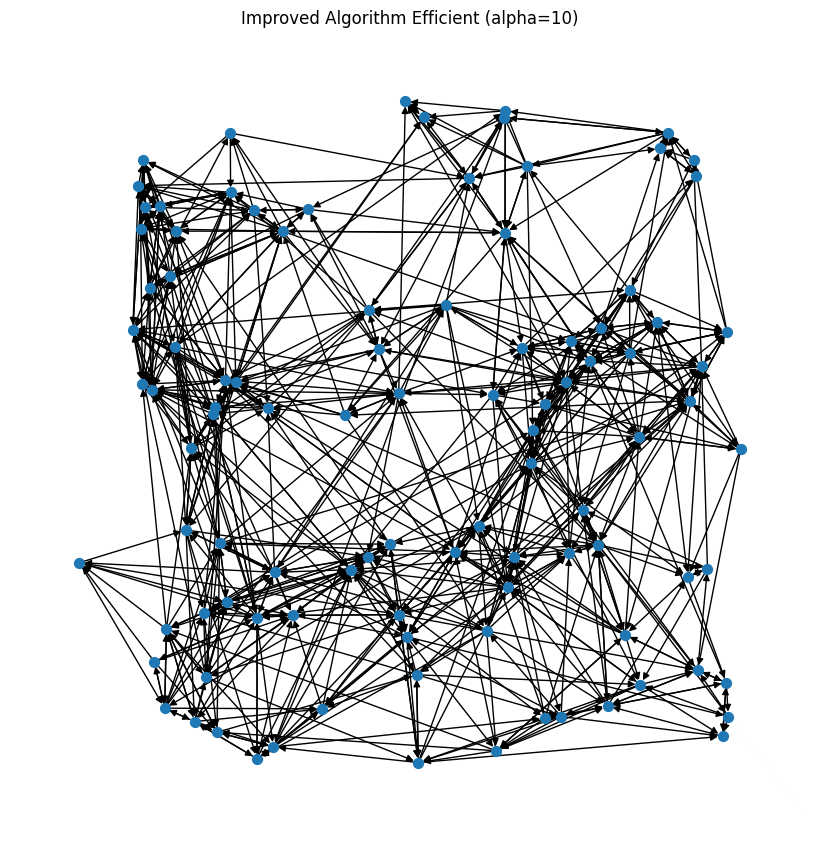

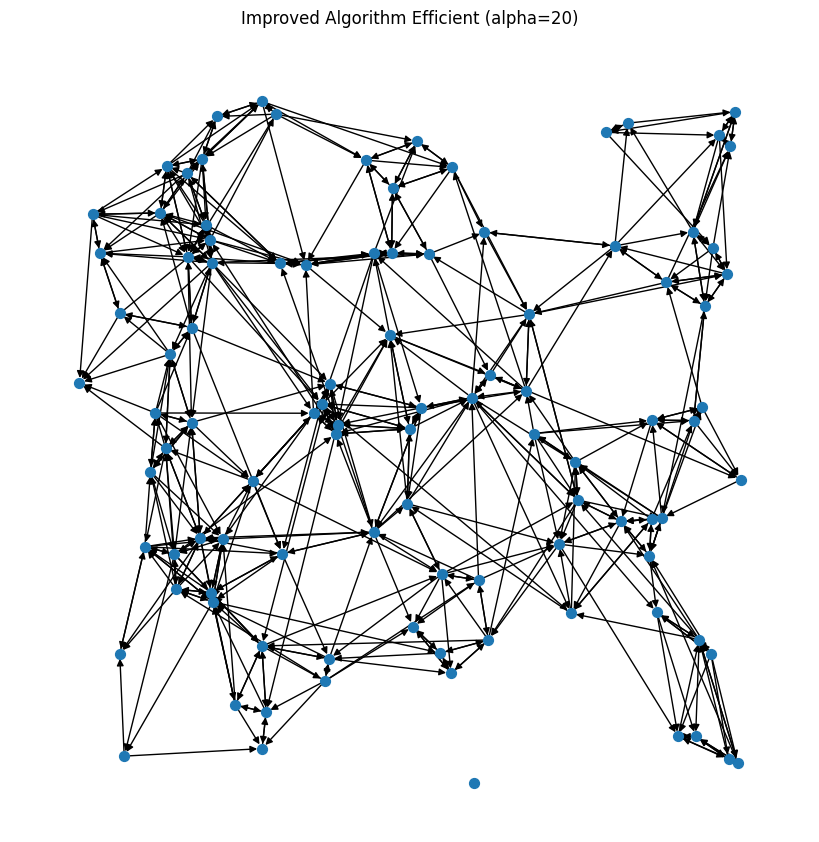

In [ ]:
results = [
    ImprovedAlgorithmEfficient(alpha=5, N=100),
    ImprovedAlgorithmEfficient(alpha=10, N=100),
    ImprovedAlgorithmEfficient(alpha=20, N=100)
]

for i, (adjacency, positions) in enumerate(results):
    G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph)
    plot_graph(G, positions, title=f'Improved Algorithm Efficient (alpha={ [5,10,20][i] })')
    plt.show()


In [8]:
# a,b = results[0]

# G = nx.from_numpy_array(a, create_using=nx.DiGraph)
# plt.figure(figsize=(8, 8))
# nx.draw(G, pos={j: b[j] for j in range(len(b))}, node_size=50, with_labels=False)
# plt.title("Network graph")
# plt.show()

In [10]:
def avg_shortest_path_length_directed(G):
    lens = []
    for u in G.nodes():
        for v in G.nodes():
            if u != v:
                if nx.has_path(G,u,v):
                    l = nx.shortest_path_length(G,u,v,weight="dist")
                    #l = nx.shortest_path_length(G,u,v)
                    lens.append(l)
    n=len(lens)
    print(sum(lens)/n)

2.2667676767676768pha 1/20
2.5066829915314766pha 2/20
3.0614223038465465pha 3/20
4.588580851283108lpha 4/20
6.224092116917626lpha 5/20
5.958711808422791lpha 6/20
4.927295132470733lpha 7/20
2.5216494845360824pha 8/20
2.2336448598130842pha 9/20
2.07ulating for alpha 10/20
2.6818181818181817pha 11/20
1.8253968253968254pha 12/20
1.5084745762711864pha 13/20
1.5733333333333333pha 14/20
1.1923076923076923pha 15/20
1.2291666666666667pha 16/20
1.2653061224489797pha 17/20
1.2culating for alpha 18/20
1.183673469387755lpha 19/20
1.2340425531914894pha 20/20


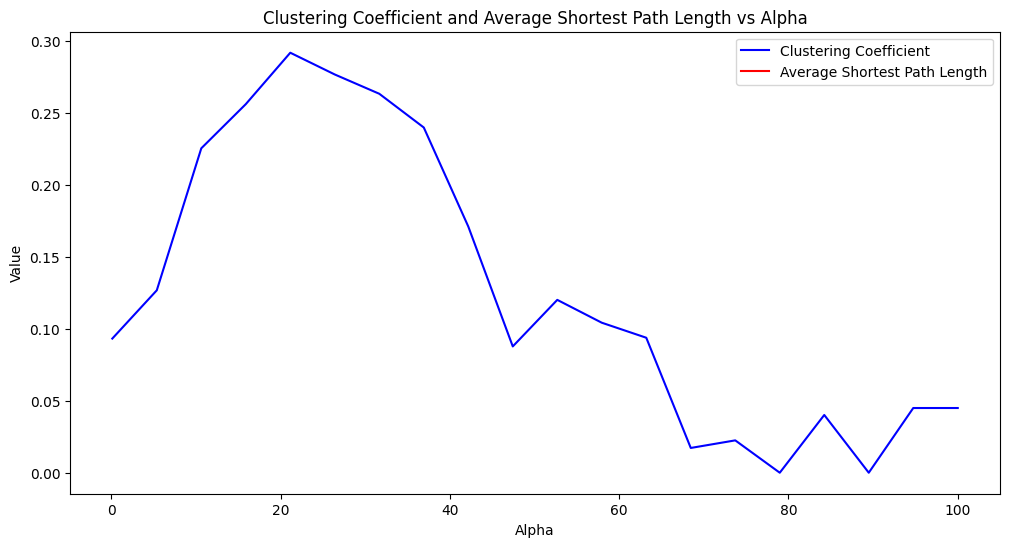

In [11]:
cluster_coefficients = []
average_shortest_paths = []
alphas = np.linspace(0.1, 100, 20)

for i, alpha in enumerate(alphas):
    print(f'Calculating for alpha {i+1}/{len(alphas)}', end='\r')
    adjacency, _ = ImprovedAlgorithmEfficient(alpha=alpha, N=100)
    G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph)

    cluster_coefficients.append(nx.average_clustering(G))
    average_shortest_paths.append(avg_shortest_path_length_directed(G))

plt.figure(figsize=(12, 6))
plt.plot(alphas, cluster_coefficients, label='Clustering Coefficient', color='blue')
plt.plot(alphas, average_shortest_paths, label='Average Shortest Path Length', color='red')
plt.xlabel('Alpha')
plt.ylabel('Value')
plt.title('Clustering Coefficient and Average Shortest Path Length vs Alpha')
plt.legend()
plt.show()


# Task 3

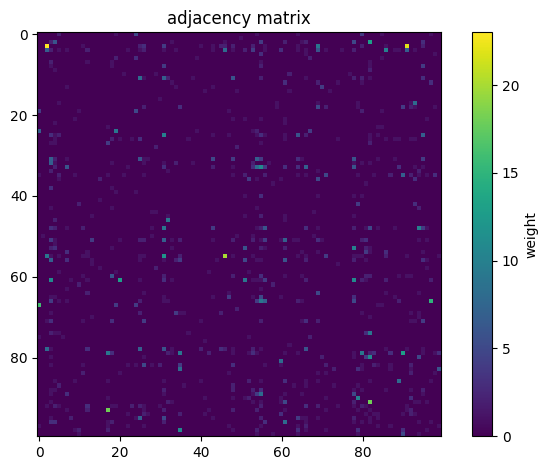

In [12]:
mouse = np.load("data/mouse_V1_adjacency_matrix.npy")
#print(mouse.shape)

plt.figure()
plt.imshow(mouse)
plt.title("adjacency matrix")
plt.colorbar(label="weight")
plt.tight_layout()

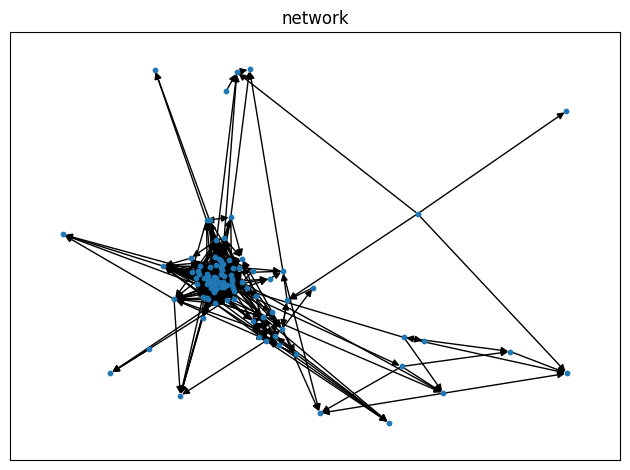

In [13]:
G = nx.from_numpy_array(mouse, create_using=nx.DiGraph)

plt.figure()

position = nx.spring_layout(G,seed=0)
nx.draw_networkx(G,pos=position,node_size=10,with_labels=False)
plt.title("network")
plt.tight_layout()
plt.show()   

In [14]:
c = nx.average_clustering(G)
print(c)

0.22784965779174798


In [15]:
avg_shortest_path_length_directed(G)

2.636455440545317


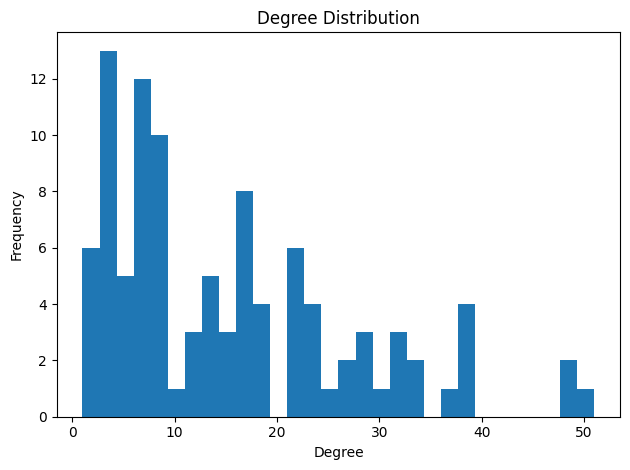

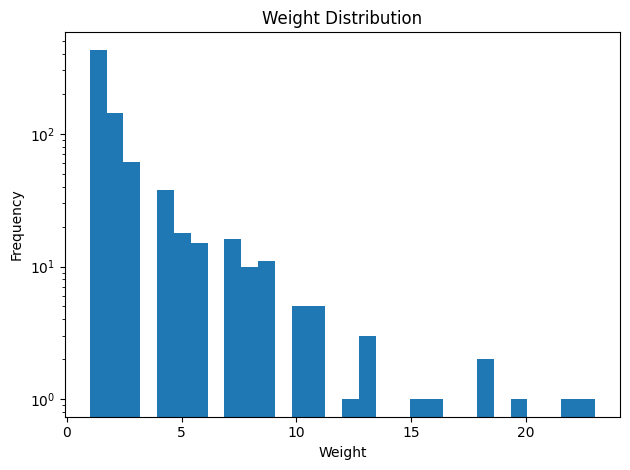

In [17]:
#weight and degree distributions
degrees = [val for (_, val) in G.degree()]
plt.figure()
plt.hist(degrees, bins=30)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

weights = [data['weight'] for (_, _, data) in G.edges(data=True)]
plt.figure()
plt.hist(weights, bins=30)      
plt.title("Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")

plt.yscale("log")

plt.tight_layout()
plt.show()

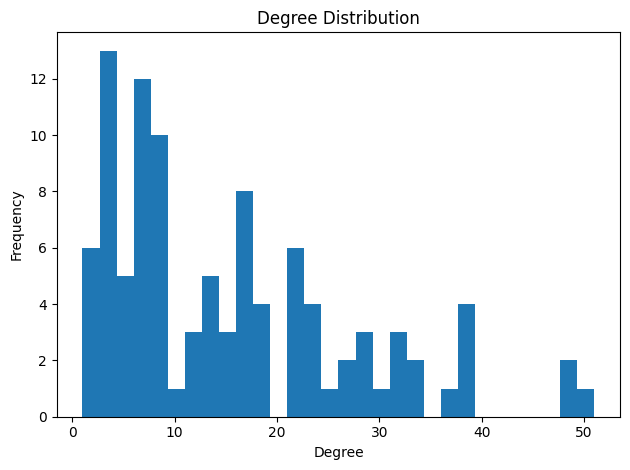

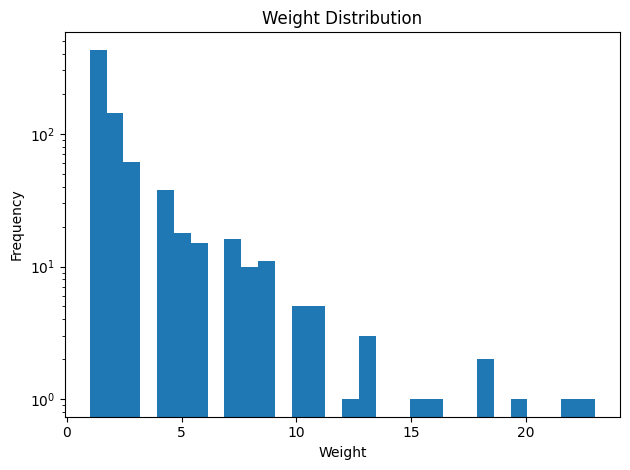

In [ ]:
#weight and degree distributions
degrees = [val for (_, val) in G.degree()]
plt.figure()
plt.hist(degrees, bins=30)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

weights = [data['weight'] for (_, _, data) in G.edges(data=True)]
plt.figure()
plt.hist(weights, bins=30)      
plt.title("Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")

plt.yscale("log")

plt.tight_layout()
plt.show()